The following notebook creates tic tac toe players using a q-learning reinforcement learning strategy

In [1]:
import random
import matplotlib 
import numpy as np 
from collections import defaultdict 

In [2]:
class BoardEnvironment:
    """ this class creates an environment for agents to interact with"""

    def __init__(self):
        "initialize board"

    def set_players(self, playerA, playerB):
        " connects players with the environment "
        self.playerA = playerA
        self.playerB = playerB
        self.reset()  # defines current_player
        self.score_board = {'X': 0, 'O': 0}

    def reset(self):
        self.turn = 'X'  # the board always starts with X, regardless of which player

        # board states are a 16-character representing the state of the board.
        self.board = list('----------------')
        self.score_board = {'X': 0, 'O': 0}
        if (self.playerA and self.playerB):  # if they are set
            self.playerA.reset_past()
            self.playerB.reset_past()
            if (random.random() < 0.5):  # randomly pick the player to start
                self.current_player = self.playerA
            else:
                self.current_player = self.playerB

    def print_board(self, board_string=None):
        "print more readable board either from supplied board string or the current board"
        if not board_string:
            B = self.board
        else:
            B = board_string

        print('*',B[0],'*',B[1],'*')
        print(B[2],B[12],B[3],B[13],B[4])
        print('*',B[5],'*',B[6],'*')
        print(B[7],B[14],B[8],B[15],B[9])
        print('*',B[10],'*',B[11],'*')


    def get_state(self):
        return "".join(self.board)

    def other_player(self):
        # note, returns other player even if playerA is playing itself
        if (self.current_player == self.playerA):
            return self.playerB
        else:
            return self.playerA

    def available_actions(self):
        return [ind for ind, val in enumerate(self.board[:12]) if val == '-']

    def other_turn(self):
        return 'X' if self.turn == 'O' else 'O'

    def play_game(self):
        # returns the winning player or None if a tie
        self.reset()
        while True:
            choice = self.current_player.select_action()

            self.board[choice] = self.turn  # should check if valid

            score = self.winner(choice)
            self.score_board[self.turn] += len(score)
            if len(score)!=0:
                #not a tie
#                 self.current_player.reward(100)
                for i in score:
                    self.board[i]=self.turn
            else:
            # switch players
                self.turn = self.other_turn()
                self.current_player = self.other_player()

            if self.is_full():
                break

        if self.score_board[self.turn] > self.score_board[self.other_turn()]:
            self.current_player.reward(100)
            self.other_player().reward(-100)
            return self.current_player
        elif self.score_board[self.turn] < self.score_board[self.other_turn()]:
            self.other_player().reward(100)
            self.current_player.reward(-100)
            return self.other_player()
        else:# it's a tie
            self.current_player.reward(0)
            self.other_player().reward(0)
            return None

    def winner(self, choice):
        boxes = (
            (0, 2, 3, 5),
            (1, 3, 4, 6),
            (5, 7, 8, 10),
            (6, 8, 9, 11)
        )
        result=[]
        for box in boxes:
            if (choice in box) and all(self.board[i] != '-' for i in box):
                if box == (0,2,3,5):
                    result.append(12)
                elif box == (1,3,4,6):
                    result.append(13)
                elif box == (5,7,8,10):
                    result.append(14)
                else:
                    result.append(15)
        
        return result  # if there is no winner

    def is_full(self):
        return ('-' not in self.board[0:12])
    # %%

In [3]:
class Agent:
    """ this class is a generic Q-Learning reinforcement learning agent for discrete states and fixed actions
    represented as strings"""
    def __init__(self, environment, policy = 'max', learning_rate = 0.5, discount_factor = 0.95, epsilon = 0.2):
        if policy in ['max', 'random', 'epsilon']:
          self.policy = policy
        else:
          raise InputError(policy, ' is not an available policy')
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.Q = defaultdict(lambda: 0.0) # stores (state, action) value tuples as keys
        self.environment = environment
        self.epsilon = epsilon # Fraction of time making a random choice for epsilon policy
        self.reset_past()

    def reset_past(self):
      self.past_action = None
      self.past_state = None
          
    def select_action(self):
      available_actions = self.environment.available_actions()
      if (self.policy == 'random') or (self.policy == 'epsilon' and random.random() < self.epsilon):
        choice = random.choice(available_actions)
      else: #self.policy == 'max' or it's an epsilon policy determined to pick the max
        Q_vals = [self.Q[(self.environment.get_state(), x)] for x in available_actions]
        #randomly pick one of the maximum values
        max_val = max(Q_vals) # will often be 0 in the beginning
        max_pos = [i for i, j in enumerate(Q_vals) if j == max_val]
        max_indices = [available_actions[x] for x in max_pos]
        choice = random.choice(max_indices)
      self.past_state = self.environment.get_state()
      self.past_action = choice
      return choice
        
    def reward(self, reward_value):
        # finding the best expected reward
        available_actions = self.environment.available_actions()
        next_Q_vals = [self.Q[(self.environment.get_state(), x)] for x in available_actions]
        max_next_Q = max(next_Q_vals) if next_Q_vals else 0 # will often be 0 in the beginning
        td_target = reward_value + self.discount_factor * max_next_Q
        reward_pred_error = td_target - self.Q[(self.past_state,self.past_action)]
        if (self.past_state or self.past_action):
          self.Q[(self.past_state,self.past_action)] += self.learning_rate * reward_pred_error


In [4]:
class RepeatedGames:
    def __init__(self, environment, playerA, playerB):
        self.environment = environment
        self.playerA = playerA
        self.playerB = playerB
        self.reset_history()
    
    def reset_history(self):
        self.history = []
    
    def play_game(self):
        winner = self.environment.play_game()
        if (winner == self.playerA):
          self.history.append('A')
        elif (winner == self.playerB):
          self.history.append('B')
        else:
          self.history.append('-')
    
    def play_games(self, games_to_play):
        for i in range(games_to_play):
            self.play_game()
        print(self.history[-games_to_play:].count('A'),'games won by player A')
        print(self.history[-games_to_play:].count('B'),'games won by player B')
        print(self.history[-games_to_play:].count('-'),'ties')

In [5]:
board = BoardEnvironment()
A = Agent(board, 'max')
B = Agent(board, 'random')
board.set_players(A,B)

tournament = RepeatedGames(board,A,B)
tournament.play_games(100)
print()
tournament.play_games(100000)
print()
tournament.play_games(100000)
print()
tournament.play_games(100000)
print()
tournament.play_games(100000)
print()
tournament.play_games(100)

40 games won by player A
37 games won by player B
23 ties

44165 games won by player A
39164 games won by player B
16671 ties

48175 games won by player A
32633 games won by player B
19192 ties

51753 games won by player A
27445 games won by player B
20802 ties

54136 games won by player A
23186 games won by player B
22678 ties

54 games won by player A
18 games won by player B
28 ties


In [6]:
tournament.play_games(100000)
print()
tournament.play_games(100)

55766 games won by player A
19867 games won by player B
24367 ties

55 games won by player A
18 games won by player B
27 ties


In [7]:
# observe the highest and lowest board state action value functions
key_max = max(A.Q.keys(), key=(lambda k: A.Q[k]))
print("highest Q for player A:", A.Q[key_max],', state_action:', key_max)
board.print_board(key_max[0])
key_max = max(B.Q.keys(), key=(lambda k: B.Q[k]))
print("\nhighest Q for player B:", B.Q[key_max],', state_action:', key_max)
board.print_board(key_max[0])
key_min = min(A.Q.keys(), key=(lambda k: A.Q[k]))
print("\nlowest Q for player A:", A.Q[key_min],', state_action:', key_min)
board.print_board(key_min[0])
key_min = min(B.Q.keys(), key=(lambda k: B.Q[k]))
print("\nlowest Q for player B:", B.Q[key_min],', state_action:', key_min)
board.print_board(key_min[0])

# print(A.Q[('XXOOXXO--', 7)], A.Q[('XXOOXXO--', 8)])


highest Q for player A: 100.0 , state_action: ('-OOXXXOOXXXX-XXX', 0)
* - * O *
O - X X X
* X * O *
O X X X X
* X * X *

highest Q for player B: 99.9999999996362 , state_action: ('-OOXXXOXXXOX-XXX', 0)
* - * O *
O - X X X
* X * O *
X X X X X
* O * X *

lowest Q for player A: -99.9755859375 , state_action: ('XOOOOXXXO-OOOOO-', 9)
* X * O *
O O O O O
* X * X *
X O O - -
* O * O *

lowest Q for player B: -99.99999925494194 , state_action: ('O-XXOOXOXOOOO-OO', 1)
* O * - *
X O X - O
* O * X *
O O X O O
* O * O *


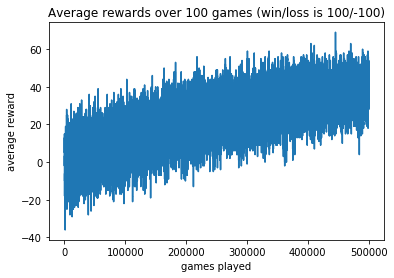

In [8]:
# plot the history
import numpy as np
import pylab as py
import matplotlib
%matplotlib inline 

history = np.array(tournament.history.copy())
rewards = np.zeros(len(history))
rewards[history == 'A'] = 100
rewards[history == 'B'] = -100

def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')
r_mean = running_mean(rewards, 100)
py.plot(r_mean)
py.xlabel('games played')
py.ylabel('average reward')
py.title('Average rewards over 100 games (win/loss is 100/-100)');

In [17]:
class LeagueEnvironment:
  """ this creates a league for players to decide if they want to play """
  def __init__(self, board_environment):
    self.board = board_environment    

  def set_players(self, player_names, league_agents, board_agents):
    self.player_names = player_names
    self.league_agents = league_agents
    self.board_agents = board_agents
    assert(len(player_names) == len(league_agents) == len(board_agents) )
    self.num_players = len(player_names)

  def reset_pair(self):
    # randomly select 2 players
    player_indices = list(range(self.num_players))
    self.Ai = random.choice(player_indices)
    player_indices.remove(self.Ai)
    self.Bi = random.choice(player_indices)

    self.board.set_players(self.board_agents[self.Ai], self.board_agents[self.Bi])
    self.league_agents[self.Ai].reset_past()
    self.league_agents[self.Bi].reset_past()
    self.A_wins = 0;
    self.A_chips=100;
    self.ties = 0;
    self.B_wins = 0;
    self.B_chips=100;
    self.state_perspective = 'A' # the state in wins/ties/losses for which player
    self.reward_mul=1
    self.min_bid=5
    self.game_counter=1

  def get_state(self):  ### how to tell who is calling get_state?
    if self.state_perspective == 'A':
      return (self.A_chips,self.ties,self.B_chips)
    else: # show for player B
      return (self.B_chips,self.ties,self.A_chips)

  def pair_games_played(self):
    return self.A_wins + self.ties + self.B_wins  

  def available_actions(self):
    if self.state_perspective=='A':
      return ['quit','single bet','double bet','triple bet']
    else:
      return ['quit','call']

  def play_pair(self): 
    # returns the winning player or None if a tie

    self.reset_pair() # picks a new random pair of players

    while (True):
      
    
      if self.game_counter%2==0:
          self.state_perspective = 'A'
          A_choice = self.league_agents[self.Ai].select_action()
          self.state_perspective = 'B'
          B_choice = self.league_agents[self.Bi].select_action()
      else:
          self.state_perspective = 'B'
          B_choice = self.league_agents[self.Bi].select_action()
          self.state_perspective = 'A'
          A_choice = self.league_agents[self.Ai].select_action()

      # is it over? then return with the overall winner
      if A_choice == 'quit' or B_choice == 'quit': 
        break;
      elif A_choice=='single bet' or B_choice=='single bet':
        self.reward_mul=1
      elif A_choice=='double bet' or B_choice=='double bet':
        self.reward_mul=2
      elif A_choice=='triple bet' or B_choice=='triple bet':
        self.reward_mul=3

        
      # now play a game    
      winner = self.board.play_game()

      # record the winner
      if winner == self.board_agents[self.Ai]:
        self.A_wins += 1
        self.A_chips+=self.min_bid*self.reward_mul
        self.B_chips-=self.min_bid*self.reward_mul
        self.state_perspective = 'A'
        self.league_agents[self.Ai].reward(self.min_bid*self.reward_mul)
#         self.state_perspective = 'B'         
#         self.league_agents[self.Bi].reward(-self.min_bid*self.reward_mul)
      elif winner == self.board_agents[self.Bi]:
        self.B_wins += 1
        self.B_chips+=self.min_bid*self.reward_mul
        self.A_chips-=self.min_bid*self.reward_mul
#         self.state_perspective = 'A'
#         self.league_agents[self.Ai].reward(-self.min_bid*self.reward_mul)
        self.state_perspective = 'B'         
        self.league_agents[self.Bi].reward(self.min_bid*self.reward_mul)
      else:
        self.ties += 1
        self.state_perspective = 'A'
        self.league_agents[self.Ai].reward(0)
        self.state_perspective = 'B'         
        self.league_agents[self.Bi].reward(0)
      
      self.game_counter+=1
      if self.A_chips<=0 or self.B_chips<=0 or self.game_counter==10:
        break;

    # when the match is over
    self.ties += 0.1 # a hack to make a new end state different from the last one

    reward_value = 100    # try self.pair_games_played() * 100?
    if self.A_chips > self.B_chips:
      self.state_perspective = 'A'
      self.league_agents[self.Ai].reward(self.A_chips-100)
      self.state_perspective = 'B'         
      self.league_agents[self.Bi].reward(self.B_chips-100)
      return (self.player_names[self.Ai], self.A_chips-100, self.player_names[self.Bi])
    elif self.A_chips < self.B_chips:
      self.state_perspective = 'A'
      self.league_agents[self.Ai].reward(self.A_chips-100)
      self.state_perspective = 'B'         
      self.league_agents[self.Bi].reward(self.B_chips-100)
      return (self.player_names[self.Bi], self.B_chips-100, self.player_names[self.Ai])
    else: #same number of wins for A and B
      self.state_perspective = 'A'
      self.league_agents[self.Ai].reward(0)
      self.state_perspective = 'B'         
      self.league_agents[self.Bi].reward(0)
      return (self.player_names[self.Ai],0,self.player_names[self.Bi])


In [18]:
board = BoardEnvironment()
league = LeagueEnvironment(board)

player_names = []
board_agents = []
league_agents = []

player_names.append('learning strategy and tactics')
board_agents.append(Agent(board, 'max'))
league_agents.append(Agent(league, 'max'))

player_names.append('learning tactics only')
board_agents.append(Agent(board, 'max'))
league_agents.append(Agent(league, 'random'))

player_names.append('learning strategy only')
board_agents.append(Agent(board, 'random'))
league_agents.append(Agent(league, 'max'))

player_names.append('no learning')
board_agents.append(Agent(board, 'random'))
league_agents.append(Agent(league, 'random'))

league.set_players(player_names, league_agents, board_agents)

history_winner = []
history_reward = []
history_loser = []

pairs_to_play = 1000000
for game in range(pairs_to_play):    
    (winner, reward, loser) = league.play_pair()
    history_winner.append(winner)
    history_reward.append(reward)
    history_loser.append(loser)

history_winner = np.array(history_winner)
history_reward = np.array(history_reward)
history_loser = np.array(history_loser)

print('results of first',pairs_to_play,'matches')
for i in range(league.num_players):
  matches_won = np.count_nonzero(np.array(history_reward > 0) & np.array(history_winner == player_names[i]) )
  print(matches_won,'matches won by player',player_names[i])

results of first 1000000 matches
79343 matches won by player learning strategy and tactics
96463 matches won by player learning tactics only
112920 matches won by player learning strategy only
70825 matches won by player no learning


In [19]:
# observe the highest and lowest board state action value functions
for pi in range(league.num_players):
  LA = league_agents[pi]
  key_max = max(LA.Q.keys(), key=(lambda k: LA.Q[k]))
  print("\nhighest Q for", player_names[pi], ":", LA.Q[key_max],', state_action:', key_max)
  key_min = min(LA.Q.keys(), key=(lambda k: LA.Q[k]))
  print("lowest Q for", player_names[pi], ":", LA.Q[key_min],', state_action:', key_min)


highest Q for learning strategy and tactics : 40.2978515625 , state_action: ((140, 2, 60), 'triple bet')
lowest Q for learning strategy and tactics : -57.371713553855834 , state_action: ((35, 0, 165), 'double bet')

highest Q for learning tactics only : 79.01943774125539 , state_action: ((155, 0, 45), 'triple bet')
lowest Q for learning tactics only : -48.125 , state_action: ((45, 0, 155), 'quit')

highest Q for learning strategy only : 45.69464389803145 , state_action: ((130, 0, 70), 'double bet')
lowest Q for learning strategy only : -65.625 , state_action: ((30, 0, 170), 'quit')

highest Q for no learning : 81.63043545350702 , state_action: ((130, 0, 70), 'double bet')
lowest Q for no learning : -55.625 , state_action: ((45, 1, 155), 'triple bet')


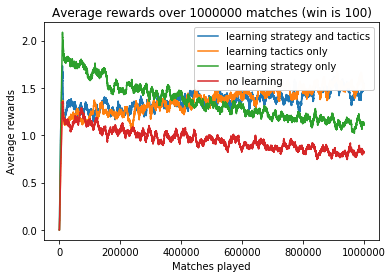

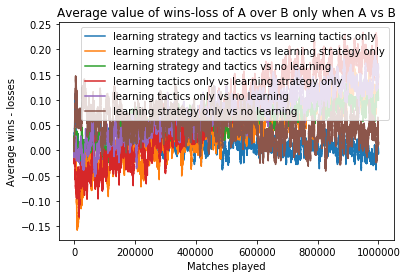

In [22]:
# plot the history
import numpy as np
import pylab as py
import matplotlib
%matplotlib inline 

def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='full')

# plot the average winnings
for pi in range(league.num_players):
  rewards = history_reward.copy()
  rewards[history_winner != player_names[pi]] = 0
  r_mean = running_mean(rewards, 10000)
  py.plot(r_mean[0:len(history_winner)]);

py.xlabel('Matches played')
py.ylabel('Average rewards')
py.title( 'Average rewards over ' + str(len(history_winner)) + ' matches (win is 100)');
py.legend(player_names, loc='upper right', framealpha=0.99);

# plot the match win percentage for each pair
py.figure()
pair_labels = []
for ai in range(league.num_players - 1):
  for bi in range(ai+1,league.num_players):
    a_vs_b_reward = np.zeros(history_reward.shape)
    pair_labels.append(player_names[ai] + ' vs ' + player_names[bi])
    for i in range(len(a_vs_b_reward)):
      if history_reward[i] > 0 and history_winner[i] == player_names[ai] and history_loser[i] == player_names[bi]:
        a_vs_b_reward[i] = 1
      if history_reward[i] > 0 and history_winner[i] == player_names[bi] and history_loser[i] == player_names[ai]:
        a_vs_b_reward[i] = -1
    r_mean = running_mean(a_vs_b_reward, 5000)
    py.plot(6 * r_mean[0:len(a_vs_b_reward)]);

py.xlabel('Matches played')
py.ylabel('Average wins - losses')
py.title( 'Average value of wins-loss of A over B only when A vs B');
py.legend(pair_labels, loc='upper right', framealpha=0.8);